In [1]:
import os
import os.path as osp
import glob
from PIL import Image
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms

In [2]:
CLASSES = ["bird", "cat", "deer", "dog", "frog", "horse"]
class Dataset(data.Dataset):
    def __init__(self, file_paths_list, transform, phase):
        self.file_paths_lsit = file_paths_list
        self.transform = transform
        self.train = True if phase=="train" else False
        
    def __len__(self):
        return len(self.file_paths_lsit)
    
    def __getitem__(self, index):
        # 読み込み
        path = self.file_paths_lsit[index]
        img = Image.open(path) # [高さ][幅][色RGB]
        
        # 前処理
        img_transformed = self.transform(img)
        
        # ラベル
        label = path.split("/")[4]
        label = CLASSES.index(label)
        
#         return img_transformed, label
        return path, img_transformed, label

In [3]:
# ファイルのpathリスト作成
train_dataset_paths = "./dataset/cifar/train/*/*"
test_dataset_paths = "./dataset/cifar/test/*/*"

train_dataset_paths_list = [_ for _ in glob.glob(train_dataset_paths)]
test_dataset_paths_list = [_ for _ in glob.glob(test_dataset_paths)]

In [4]:
print("len(train_dataset_paths_list):", len(train_dataset_paths_list)) # 6クラス * 5000枚/クラス = 30000枚
print("len(test_dataset_paths_list):", len(test_dataset_paths_list))

len(train_dataset_paths_list): 30000
len(test_dataset_paths_list): 4000


In [5]:
# 前処理インスタンスの定義
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
# train_datasetインスタンスの宣言
train_dataset = Dataset(train_dataset_paths_list, data_transforms, "train")

In [25]:
class TripletCIFAR(Dataset):
    """
    Train: For each sample (anchor) randomly chooses a positive and negative samples
    Test: Creates fixed triplets for testing
    """

    def __init__(self, train_dataset, train_labels):
        self.train_dataset = train_dataset
        self.train = True
        self.train_labels = train_labels

        self.train_labels = self.train_labels
        self.train_data = self.train_dataset
        self.labels_set = set(self.train_labels)
        self.label_to_indices = {label: np.where(self.train_labels == label)[0] for label in self.labels_set}


    def __getitem__(self, index):
#         img1, label1 = self.train_data[index][1], self.train_labels[index]
        path1, img1, label1 = self.train_data[index][0], self.train_data[index][1], self.train_data[index][2]
        positive_index = index
        while positive_index == index:
            positive_index = np.random.choice(self.label_to_indices[label1])
        negative_label = np.random.choice(list(self.labels_set - set([label1])))
        negative_index = np.random.choice(self.label_to_indices[negative_label])
        path2, img2, label2 = self.train_data[positive_index]
        path3, img3, label3 = self.train_data[negative_index]
        
        return (path1, path2, path3), (img1, img2, img3), (label1, label2, label3)
    
    def __len__(self):
        return len(self.train_dataset)

In [26]:
# データのラベルを格納したリスト
train_labels = np.array([train_dataset[index][2] for index in range(len(train_dataset))])

In [27]:
triplet_train_dataset = TripletCIFAR(train_dataset, train_labels)

In [28]:
batch_size = 32
triplet_train_loader = data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True)

In [29]:
# ネットワーク定義
class EmbeddingNet(nn.Module):
    """ Basic Embedding Network
    """
    def __init__(self, fc_input_size=64*6*6):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.Conv2d(32, 64, 3),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    )
        self.fc = nn.Sequential(nn.Linear(fc_input_size, 256),
                                nn.ReLU(),
                                nn.Linear(256, 64),
                                )
    
    def forward(self, x):
        """ convnet -> flatten -> fc 
            input: torch.Size([batch_size, 3, 64, 64])
            output: torch.Size([batch_size, 64])
        """
        x = self.convnet(x)
        batch_size = x.size(0)
        x = x.view(batch_size, -1) # flatten
        x = self.fc(x)
        return x


class EmbeddingNetL2(EmbeddingNet):
    """ output l2 norm
    """
    def __init__(self):
        super(EmbeddingNetL2, self).__init__()

    def forward(slef, x):
        x = super(EmbeddingNetL2, self).forward(x)
        x /= x.pow(2).sum(1, keepdim=True).sqrt()
        return x

In [30]:
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net
        
    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3
    
    def get_embedding(self, x):
        return self.embedding_net(x)

In [31]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [45]:
margin = 10
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
model.to("cuda")
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs=100
log_interval=100

In [ ]:
import time

# 時間計測開始
time_sta = time.perf_counter()

# fit 関数をそのまま書く
start_epoch = 0
losses = []
total_loss = 0

# train
for epoch in range(start_epoch, n_epochs):
    scheduler.step()
    model.train()
    losses = []
    total_loss = 0
    for batch_idx, (paths, datas, labels) in enumerate(triplet_train_loader):
        x1, x2, x3 = datas
        x1, x2, x3 = x1.to("cuda"), x2.to("cuda"), x3.to("cuda")
        optimizer.zero_grad()
        outputs = model(x1, x2, x3) # data = ([(x11, x12), (x21, x22), ....])
        output1, output2, output3 = outputs
        loss = loss_fn(output1, output2, output3)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    time_end = time.perf_counter()
    # 経過時間（秒）
    tim = time_end- time_sta
    print("epoch:", epoch, "loss:", loss.item(), "time:", tim)

/home/gesogeso/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch: 0 loss: 7.320002555847168 time: 56.498248602001695
epoch: 1 loss: 7.393443584442139 time: 111.62330686900532
epoch: 2 loss: 4.634161949157715 time: 166.59085794302518
epoch: 3 loss: 8.096643447875977 time: 221.54826559202047


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
CLASSES = ["bird", "cat", "deer", "dog", "frog", "horse"]
classes_num = [i for i in range(len(CLASSES))]
colors = ["red", "blue", "pink", "orange", "yellow", "green"]
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(len(CLASSES)):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.xlim(ylim[0], ylim[1])
    plt.legend(CLASSES)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 64))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for paths, images, targets in dataloader:
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = targets.numpy()
            k += len(images)
    return embeddings, labels

In [ ]:
model.cpu()
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
train_embeddings, train_labels = extract_embeddings(train_loader, model)

In [ ]:
import umap
um = umap.UMAP()
um.fit(train_embeddings)
train_embeddings_umap = um.transform(train_embeddings)

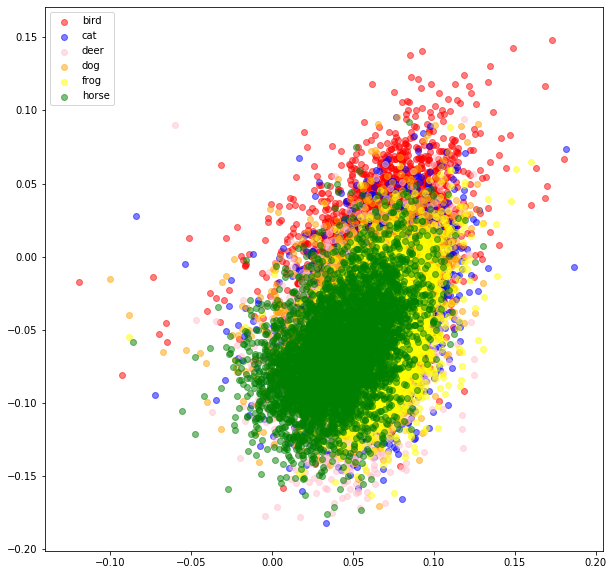

In [42]:
# plot_embeddings(train_embeddings, train_labels)

In [ ]:
plot_embeddings(train_embeddings, train_labels)

In [43]:
# from sklearn.manifold import TSNE

# X_embedded = TSNE(n_components=2).fit_transform(train_embeddings)

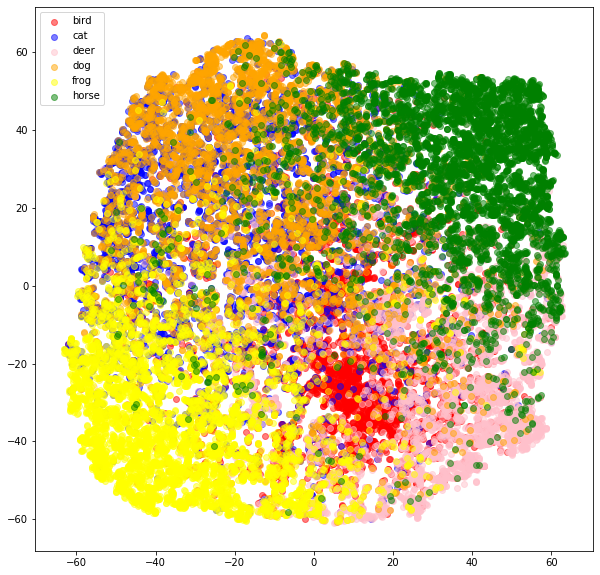

In [44]:
# plot_embeddings(X_embedded, train_labels)

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(train_embeddings)
plot_embeddings(X_embedded, train_labels)